
**Note:** If you lanch it first time, so you don't have images in your Google Drive, run this:

In [1]:
# unzip the uploaded data into Google Drive
#!unzip "/content/drive/My Drive/Oregon_Wildlife/wildlife.zip" -d "/content/drive/My Drive/Oregon_Wildlife/"

# Using Transfer Learning and TensorFlow 2.0 to Classify Different Kinds of Animals

In this project we're going to be using machine learning to help us identify different kinds of animals from Oregon.

## 1. Problem
This kind of problem is called multi-class image classification. It's multi-class because we're trying to classify mutliple different kinds of animals.

## 2. Data 

The data we're using is from Kaggle : https://www.kaggle.com/virtualdvid/oregon-wildlife

## 3. Evaluation

The evaluation is a prediction of probabilities having pneumonia for each image.

## 4. Features

Here we find a small data set of 14013 images in the folder `oregon_wildlife.zip` distributed in 20 classes as follows:

* baldeagle images: 748 
* blackbear images: 718
* cougar images: 680
* elk images: 660
* graywolf images: 730 
* mountainbeaver images: 577
* bobcat images: 696
* nutria images: 701
* coyote images: 736
* columbianblack-taileddeer images: 735
* seals images: 698
* canadalynx images: 717 
* ringtail images: 588 
* redfox images: 759
* grayfox images: 668 
* virginiaopossum images: 728
* sea_lions images: 726
*raccoon images: 728
* raven images: 656
* deer images: 764


### Get our workspace ready

* Import TensorFlow 2.x
* Import TensorFlow Hub
* Make sure we're using a GPU

**Note:** For GPU : Edit > Notebook settings or Runtime>Change runtime type and select GPU as Hardware accelerator.



In [2]:
# import TensorFlow into Colab
import tensorflow as tf
print("TF version:", tf.__version__)
# import TensorFlow Hub into Colab
import tensorflow_hub as hub
print("TF Hub version:", hub.__version__)
# check for GPU availability
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

TF version: 2.3.0
TF Hub version: 0.10.0
GPU available


**Preparing the tools:**

* pandas for data analysis
* NumPy for numerical operations
* Matplotlib/seaborn for plotting of data visualization

In [3]:
# regular EDA and plotting libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# data parsing
import os
from sklearn.utils import shuffle
# convert images
from matplotlib.pyplot import imread
# view image
import IPython.display as display
from IPython.display import Image
# split data
from sklearn.model_selection import train_test_split
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

### Preparing data sets

We have a few folders with images of each animal.

So, let's create 2 arrays: 
* one array with ALL filepaths to images and one - it will be our features (X)
* one array with ALL kinds of animals - it will be our labels (y). Each element of this array in turn is an array of zeros and one 1. 1 is on position, which means a kind of animal in list of labels.

In [37]:
kind_animal = os.listdir('/content/drive/My Drive/Oregon_Wildlife/oregon_wildlife/oregon_wildlife')
curr_path = '/content/drive/My Drive/Oregon_Wildlife/oregon_wildlife/oregon_wildlife/'
for kind in kind_animal:
  for filepath in os.listdir(curr_path + kind):
    if not filepath.endswith('.jpg') or filepath.startswith('.'):
      path = curr_path + kind
      path += '/' + filepath
      os.remove(path)

In [39]:
# get all folders names
kind_animal = os.listdir('/content/drive/My Drive/Oregon_Wildlife/oregon_wildlife/oregon_wildlife')
# create an empty list to file paths
filepaths = []
# create an empty list to labels
labels = []
# create an empty list to count number of each kind of animal
number_animal_images = []
curr_path = '/content/drive/My Drive/Oregon_Wildlife/oregon_wildlife/oregon_wildlife/'
for index, kind in enumerate(kind_animal):
  # add quantity of animals in current folder
  size = len(os.listdir(curr_path + kind))
  number_animal_images.append(size)
  # create an array of zeroes
  curr_labels = np.zeros(len(kind_animal))
  # pick 1 to position of current kind of animal
  curr_labels[index] = 1
  # add current labels to all labels for each animal
  for _ in range(size):
    labels.append(curr_labels)
  # add all paths to images in current folder
  for filepath in os.listdir(curr_path + kind):
    filepaths.append(os.path.join(curr_path + kind, filepath))

In [40]:
# see if number of labels matches the number of filenames
if len(labels) == len(filepaths):
  print("Number of labels matches number of filenames!")
else:
  print("Number of labels does not match number of filenames, check data directories.")

Number of labels matches number of filenames!


Let's figure out how many images there are of each animal.

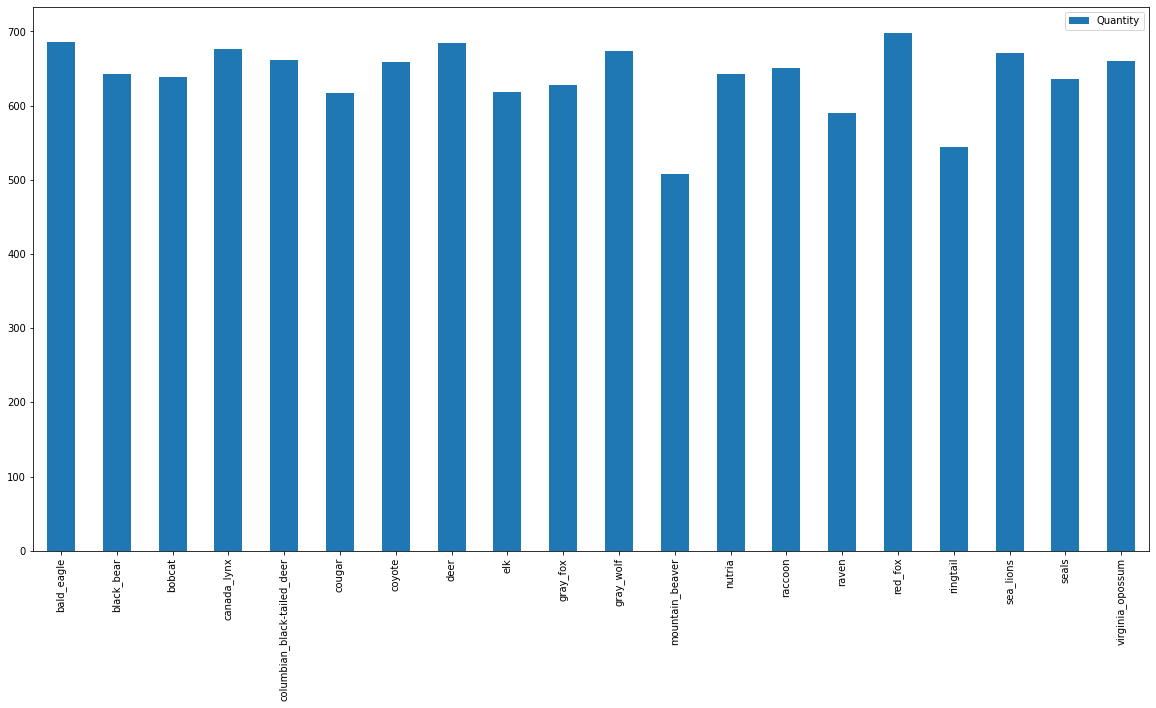

In [41]:
pd.DataFrame(number_animal_images, index=kind_animal, columns=["Quantity"]).plot.bar(figsize=(20, 10));

Let's visualize an image directly from a filepath.

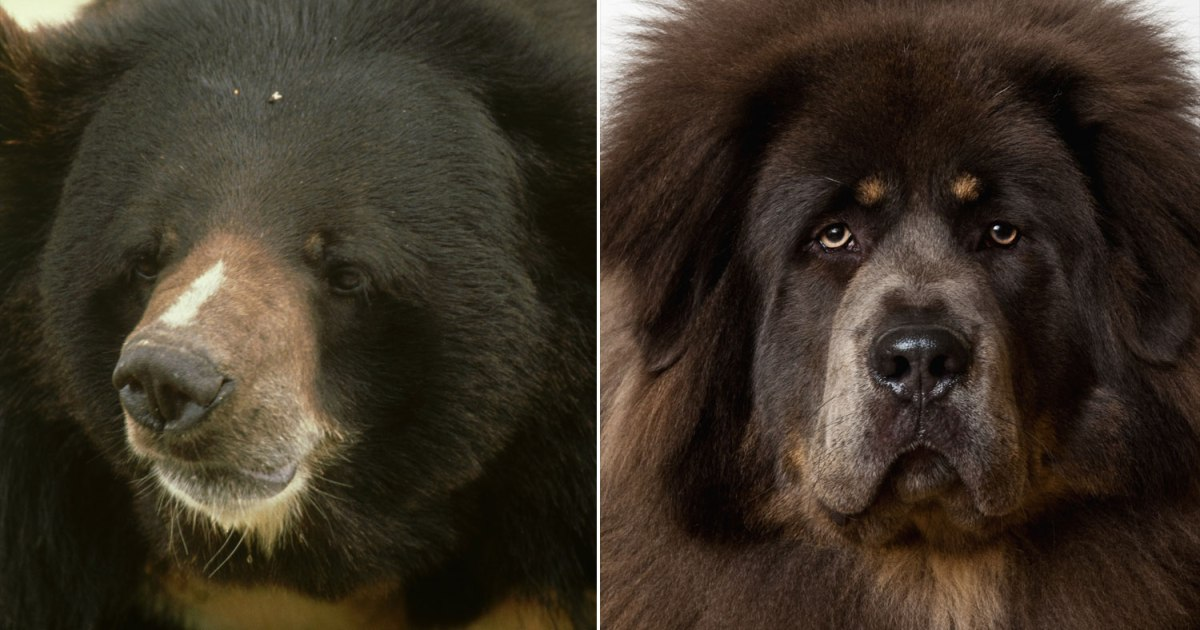

In [42]:
# check image
Image(filepaths[777])

In [43]:
# check filepath, label 
filepaths[777], labels[777]

('/content/drive/My Drive/Oregon_Wildlife/oregon_wildlife/oregon_wildlife/black_bear/22e69a0d1e2bf15f9b.jpg',
 array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]))

### Turning images into Tensors

To build a model all data must be in a numerical format, but our images are paths now. So, we'll use TensorFlow and we have to turn images into Tensors.

> Tensor is a way to represent information into numbers. Tensors also give us an opportunity to be used on a GPU.

To preprocess our images into Tensors, we're going to write a fucntion, which:

1. Takes an image as a path.
2. Read image file, using TensorFlow.
3. Turn image into Tensor.
4. Resize the image to be of shape (224, 224) (for using model to learning).
5. Return the Tensor image.

In [44]:
# define image size
IMAGE_SIZE = 224

# create a preprocess function
def preprocess_image(image_path, image_size=IMAGE_SIZE):
  """
  Takes an image path and convert it to Tensor.
  image_path : string, full path to image
  image_size : int 
  """
  # read image file
  image = tf.io.read_file(image_path)
  # turn image into Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.io.decode_jpeg(image, channels=3)
  # convert colour channels values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # resize image to IMAGE_SIZE
  image = tf.image.resize(image, size=[image_size, image_size])
  # return Tensor image
  return image

Let's check how our function will work.

In [45]:
# check a preprocess function
preprocess_image(filepaths[777])

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.8890976 , 0.9329701 , 0.763975  ],
        [0.91355485, 0.93708426, 0.7922663 ],
        [0.9176471 , 0.9490197 , 0.7960785 ],
        ...,
        [0.94473046, 0.94473046, 0.94473046],
        [0.9429975 , 0.9429975 , 0.9429975 ],
        [0.9469186 , 0.9469186 , 0.9469186 ]],

       [[0.8743042 , 0.8868567 , 0.72728467],
        [0.90124303, 0.94660807, 0.7945379 ],
        [0.92016375, 0.94650304, 0.80392164],
        ...,
        [0.9383579 , 0.9383579 , 0.9383579 ],
        [0.94117653, 0.94117653, 0.94117653],
        [0.9469186 , 0.9469186 , 0.9469186 ]],

       [[0.8303222 , 0.78844106, 0.63484335],
        [0.90209216, 0.95113796, 0.7974922 ],
        [0.9207284 , 0.94467795, 0.8113446 ],
        ...,
        [0.9335567 , 0.9335567 , 0.9335567 ],
        [0.9429975 , 0.9429975 , 0.9429975 ],
        [0.9469186 , 0.9469186 , 0.9469186 ]],

       ...,

       [[0.08730305, 0.08730305, 0.04024423],
        [0.13

### Create data batches

When we have, let's say, 10,000+ images and try to compute them, it may take up more memory than GPU has. So, we'll create small batches of your data and compute on one batch at a time.

> Batch is a small porion of data, for example 32 images and their labels.

Let's create a function to convert our data into batches.


In [46]:
# define the batch size
BATCH_SIZE = 32

# create secondary function
def get_image_label(image_path, label):
  """
  Return a tuple of (Tensor image, label).
  image_path : stirng,
  label : array
  """
  return preprocess_image(image_path), label

# create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths
    data_batch = data.map(preprocess_image).batch(batch_size)
    print("Test data batches created!")
    return data_batch

  # If the data is a validation dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y))) # filepaths and labels
    data_batch = data.map(get_image_label).batch(batch_size)
    print("Validation data batches created!")
    return data_batch

  # If the data is a validation dataset, we don't need to shuffle it
  else:
    print("Creating train data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y))) # filepaths and labels
    # shuffle data 
    data = data.shuffle(buffer_size=len(x))
    # create (image, label) tuples
    data_batch = data.map(get_image_label).batch(batch_size)
    print("Train data batches created!")
    return data_batch

### Creating datasets

To train and test a model we need split our data into datasets. We want to get:

1. Train data (~70% data)
2. Validation data (~15% data)
3. Test data (~15% data)

Let's split data using `train_test_split`.

In [47]:
# split data into full-train and test data
X, X_test, y, y_test = train_test_split(filepaths, labels, test_size=0.15, random_state=42)
# split full-train data into train and validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val), len(X_test), len(y_test)

(9237, 9237, 1631, 1631, 1918, 1918)

Using `create_data_batches` function, let's create 3 datasets.

In [48]:
# create data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)
test_data = create_data_batches(X_test, y_test, test_data=True)

Creating train data batches...
Train data batches created!
Creating validation data batches...
Validation data batches created!
Creating test data batches...
Test data batches created!


In [49]:
# check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec, test_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 20), dtype=tf.float64, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 20), dtype=tf.float64, name=None)),
 TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None))

Let's visualize our data batches. To do it, we'll create function, which displays, for example, 25 images and their labels.

In [50]:
# create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays 25 images from a data batch.
  """
  plt.figure(figsize=(15, 15))
  # loop through 25 
  for i in range(25):
    # 5 rows, 5 columns
    ax = plt.subplot(5, 5, i + 1)
    # display an image
    plt.imshow(images[i])
    # add label as a title
    plt.title(kind_animal[labels[i].argmax()])
    # turn off grid lines
    plt.axis('off')

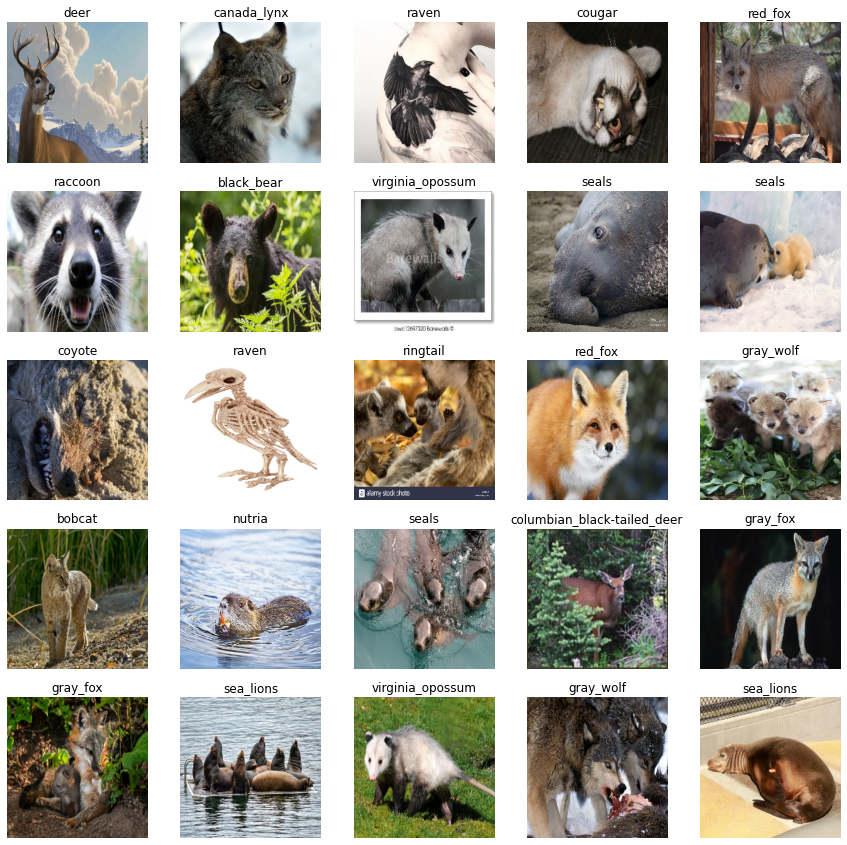

In [51]:
# visualize training images from the training data batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

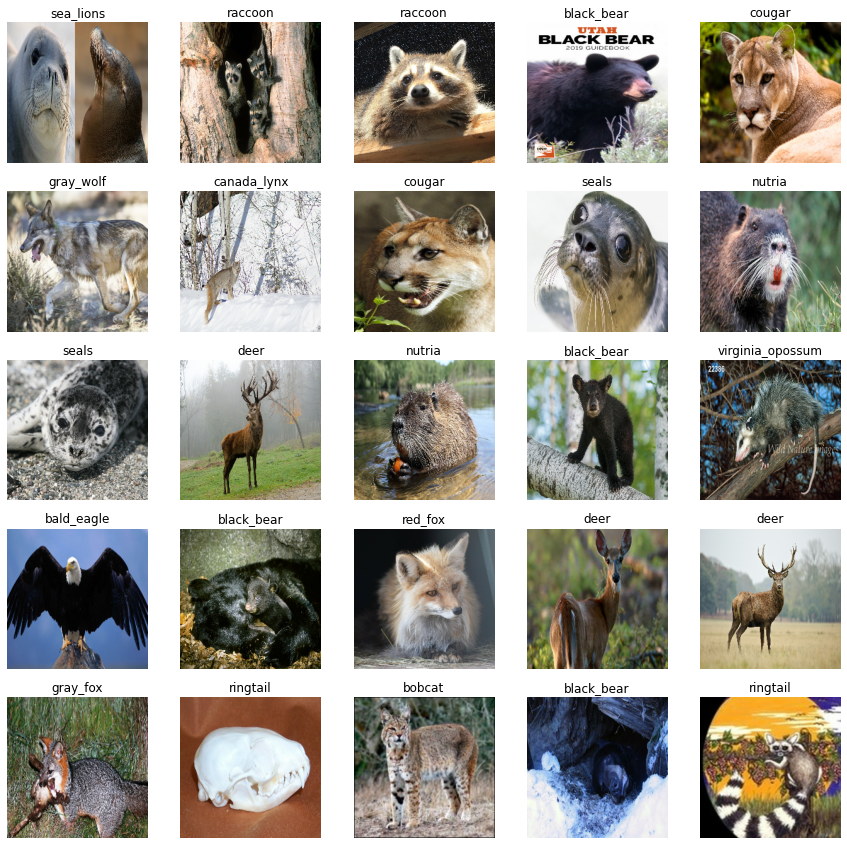

In [52]:
# visualize validation images from the validation data batch
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Create and train a model

Our problem is an image classification. Let's search a model on:

https://tfhub.dev/s?module-type=image-classification

We'll use mobilenet_v2_130_224 model and notice that this model using input image in the shape 224, 224.

https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4

### Building a model

Define:

* The input shape (Tensor images)
* The output shape (Tensor labels)
* The URL of the model we want to use




In [53]:
# setup input shape to the model
INPUT_SHAPE = [None, IMAGE_SIZE, IMAGE_SIZE, 3] # batch, height, width, colour channels

# setup output shape to the model
OUTPUT_SHAPE = len(kind_animal)

# setup URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

Let's create a fuction to build model:

* Take the imput shape, output shape and model URL as parameters.
* Define the layers in a Keras model in a sequential fashion.

In [54]:
# create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # setup the model layers
  model = tf.keras.Sequential([
      hub.KerasLayer(model_url), #layer 1 (input layer)
      tf.keras.layers.Dense(units=output_shape,
                            activation="softmax") #layer 2 (output_layer)
  ])

  # compile the model 
  model.compile(
      # loss = 0 in perfect case - how well model guessing
      loss=tf.keras.losses.CategoricalCrossentropy(), 
      # optimizer - function which helps to model improve it's guessing
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"] # way of evaluating those guesses
  )

  # build the model
  model.build(input_shape) # let the model know what kind of inputs it'll be getting
  print("Ready!")
  return model


In [29]:
# create model
model_mobile_net = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Ready!


In [30]:
# check model details
model_mobile_net.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              5432713   
_________________________________________________________________
dense (Dense)                (None, 20)                20040     
Total params: 5,452,753
Trainable params: 20,040
Non-trainable params: 5,432,713
_________________________________________________________________


### Creating callback

Before we train model, let's create a callback function.

> Callback is a helper function a model can use during training to do things such as save a models progress, check a models progress or stop training early if a model stops improving.

We'll create an Early Stopping Callback. It helps prevent overfitting by stopping a model when a certain evaluation metric stops improving. 

In [31]:
# create early stopping callback (when model stops improving, stop training)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3) # stops after 3 rounds of no improvements

### Training model

Let's define number of epochs.

> Number of epochs defines how many passes of the data we'd like our model to do. A pass is equivalent to our model trying to find patterns in each image and see which patterns relate to each label.

For example, if NUM_EPOCHS=1, the model will only look at the data once and will probably score badly because it hasn't a chance to correct itself.

In [55]:
# how many rounds should we get the model to look through the data?
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:200, step:10}

Now we're ready to create a function to train model. This function will:

* Create a model, using `create_model()`.
* Call the fit() function on our model passing it the training data, validatation data, number of epochs to train for and the callbacks we'd like to use.
* Return the fitted model.

In [56]:
# create a function to train and return a trained model 
def train_model(train_data, val_data, input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL, 
                num_epochs=NUM_EPOCHS):
  """
  Create model, trains it and returns the trained version.
  """
  # create a model
  model = create_model()

  # create an early stopping callback
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3) # stops after 3 rounds of no improvements

  # fit the model
  model.fit(x=train_data,
            epochs=num_epochs, 
            validation_data=val_data,
            validation_freq=1, # check validation metrics every epoch
            callbacks=[early_stopping]
            )
  return model

All the functions ready, let's train model!

In [57]:
# fit the model to the data
model_mobile_net_trained = train_model(train_data, val_data)

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Ready!
Epoch 1/100
289/289 [==============================] - 3666s 13s/step - loss: 0.7116 - accuracy: 0.7877 - val_loss: 0.4350 - val_accuracy: 0.8755
Epoch 2/100
289/289 [==============================] - 197s 682ms/step - loss: 0.3081 - accuracy: 0.9014 - val_loss: 0.3808 - val_accuracy: 0.8915
Epoch 3/100
289/289 [==============================] - 194s 672ms/step - loss: 0.2217 - accuracy: 0.9311 - val_loss: 0.3626 - val_accuracy: 0.8994
Epoch 4/100
289/289 [==============================] - 191s 659ms/step - loss: 0.1745 - accuracy: 0.9485 - val_loss: 0.3516 - val_accuracy: 0.9019
Epoch 5/100
289/289 [==============================] - 204s 707ms/step - loss: 0.1445 - accuracy: 0.9591 - val_loss: 0.3226 - val_accuracy: 0.9178
Epoch 6/100
289/289 [==============================] - 217s 749ms/step - loss: 0.1253 - accuracy: 0.9660 - val_loss: 0.3268 - val_accuracy: 0.9166
Epoch 7/100
289/289

## Making predictions using a trained model and visualize results.

### Making predictions

Let's make predictions on the validation data by calling `predict()` function.

In [58]:
# make predictions
predictions_mobile_net = model_mobile_net_trained.predict(val_data, 
                                                    verbose=1) # verbose=1 to show a progress

51/51 [==============================] - 31s 602ms/step


Our prediction arranged in a follow way:
every element of array is a probability, that current image is a animal corresponding to the index in all kinds of animals array.

In [63]:
# check prediction
print(predictions_mobile_net[0])
print(f"Predicted label: {kind_animal[np.argmax(predictions_mobile_net[0])]}") # the predicted label

[1.1717043e-07 3.3264522e-10 5.6077087e-10 3.7837649e-09 2.1245412e-09
 9.0740880e-11 7.7839202e-12 1.8215915e-10 1.3929939e-10 1.4401881e-12
 3.7352064e-09 5.5233865e-08 1.5608725e-08 7.8311404e-16 2.7320224e-08
 3.7271049e-14 3.2841030e-12 5.5536824e-01 4.4463155e-01 2.2732053e-12]
Predicted label: sea_lions


For convenience, let's create a function to get predicted label by a prediction probability.

In [65]:
# get label by prediction
def get_prediction_label(prediction_probability):
  """
  Returns a predicted label.
  prediction_probability : array
  """
  return kind_animal[np.argmax(prediction_probability)]

print(get_prediction_label(predictions_mobile_net[0]))

sea_lions


### Unbatch data

Since our validation data (val_data) is in batch form, to get a list of validation images and labels, we'll have to unbatch it (using unbatch()) and then turn it into an iterator using as_numpy_iterator().

In [66]:
# create a function to unbatch a batched dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separate arrays
  of images and labels.
  """
  images, labels = [], []
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(kind_animal[np.argmax(label)])
  return images, labels

# unbatchify validation data
val_images_unbatch, val_labels_unbatch = unbatchify(val_data)
val_images_unbatch[0], val_labels_unbatch[0]

(array([[[0.7607844 , 0.7607844 , 0.7686275 ],
         [0.76106447, 0.76106447, 0.7689076 ],
         [0.76470596, 0.76470596, 0.7725491 ],
         ...,
         [0.49803925, 0.3803922 , 0.24705884],
         [0.49411768, 0.37647063, 0.24313727],
         [0.49411768, 0.37647063, 0.24313727]],
 
        [[0.7607844 , 0.7607844 , 0.7686275 ],
         [0.76106447, 0.76106447, 0.7689076 ],
         [0.76470596, 0.76470596, 0.7725491 ],
         ...,
         [0.49803925, 0.3803922 , 0.24705884],
         [0.49411768, 0.37647063, 0.24313727],
         [0.4901961 , 0.37254903, 0.2392157 ]],
 
        [[0.7615347 , 0.7615347 , 0.7693778 ],
         [0.7630153 , 0.7630153 , 0.7708584 ],
         [0.76470596, 0.76470596, 0.7725491 ],
         ...,
         [0.49803925, 0.3803922 , 0.24705884],
         [0.49411768, 0.37647063, 0.24313727],
         [0.48827535, 0.37062827, 0.23729496]],
 
        ...,
 
        [[0.18263265, 0.23361304, 0.26890716],
         [0.18626471, 0.2372451 , 0.27253

### Visualize results

Let's create a function, which:

* Displays image
* Shows the result of predictions, probability and real result.

In [81]:
# create a function to visualize prediction
def plot_pred(predictions, labels, images, n=1):
  """
  View the prediction, ground truth label and image for sample n.
  """
  # using n_th result
  prediction, true_label, image = predictions[n], labels[n], images[n]

  # get the prediction label
  prediction_label = get_prediction_label(prediction)

  # plot image
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])
  
  # colour of title of image
  if prediction_label == true_label:
    color = "green"
  else:
    color = "red"

  plt.title("Prediction : {} with {:2.0f}%, True : ({})".format(prediction_label,
                                      np.max(prediction)*100,
                                      true_label),
                                      color=color)

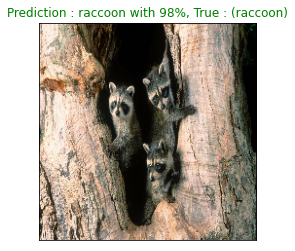

In [82]:
# view an example prediction, original image and truth label
plot_pred(predictions=predictions_mobile_net,
          labels=val_labels_unbatch,
          images=val_images_unbatch)

In [102]:
# create a function to plot first 10 probabilities
def plot_pred_conf(predictions, labels, n=1):
  """
  Plots the top 10 highest prediction confidences along with
  the truth label for sample n.
  """
  # using n_th result
  prediction, true_label = predictions[n], labels[n]

  # get the prediction label
  prediction_label = get_prediction_label(prediction)

  # find the top 10 prediction confidence indexes
  top_10_pred_indexes = prediction.argsort()[-10:][::-1]
  # find the top 10 prediction confidence values
  top_10_pred_values = prediction[top_10_pred_indexes]
  # find the top 10 prediction labels
  top_10_pred_labels = []
  for index in top_10_pred_indexes:
    top_10_pred_labels.append(kind_animal[index])
  
  # setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)), 
                     top_10_pred_values, 
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")

  # change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

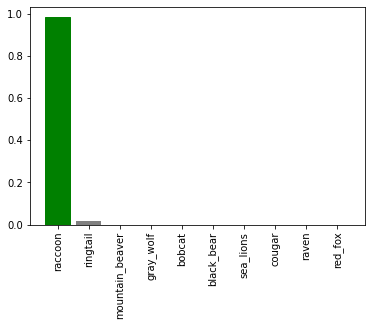

In [103]:
# view an example plot_pred_conf()
plot_pred_conf(predictions=predictions_mobile_net,
               labels=val_labels_unbatch)

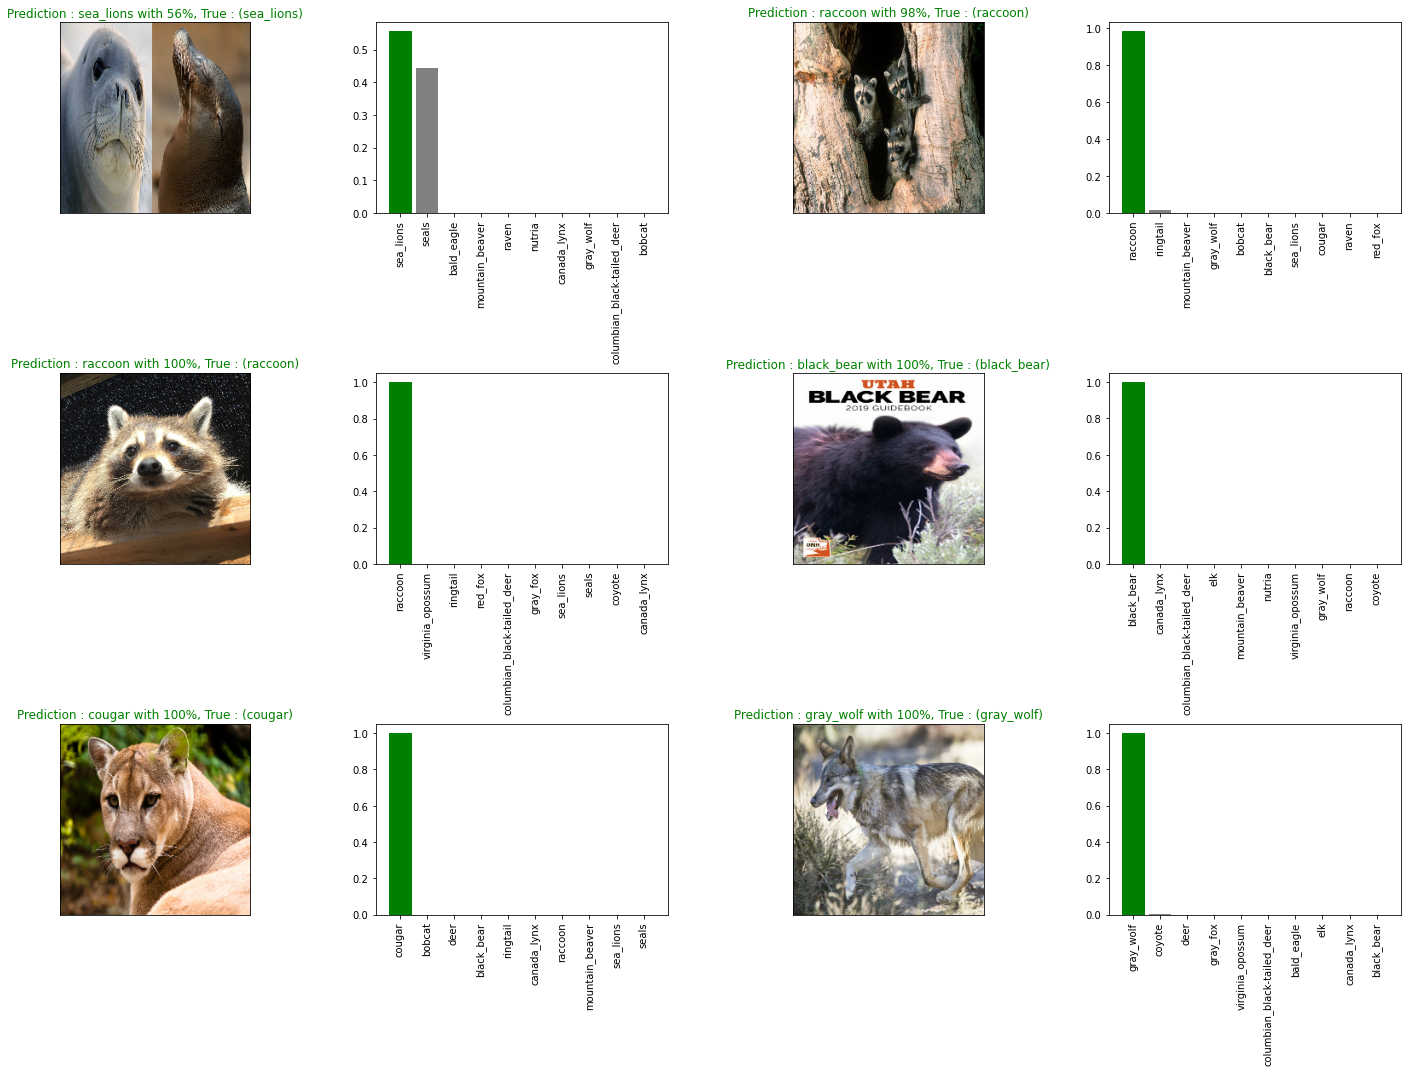

In [104]:
# let's check a few predictions and their different values
i_multiplier = 0
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(5*2*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(predictions=predictions_mobile_net,
          labels=val_labels_unbatch,
          images=val_images_unbatch,
          n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(predictions=predictions_mobile_net,
               labels=val_labels_unbatch,
               n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

Let's use a test data and make predictions on it.

In [108]:
# make predictions on test data
test_predictions = model_mobile_net_trained.predict(test_data, verbose=1)

60/60 [==============================] - 653s 11s/step


In [113]:
# get test images
test_images = next(test_data.as_numpy_iterator())

# get test labels
test_labels = []
for tmp in y_test:
  test_labels.append(kind_animal[np.argmax(tmp)])

test_images[0], test_labels[0]

(array([[[0.65882355, 0.6666667 , 0.6156863 ],
         [0.66159713, 0.66944027, 0.6184599 ],
         [0.66475344, 0.6725966 , 0.6216162 ],
         ...,
         [0.67960185, 0.66783714, 0.6090136 ],
         [0.66910255, 0.6612594 , 0.6024359 ],
         [0.6709484 , 0.66310525, 0.6042817 ]],
 
        [[0.6627451 , 0.67058825, 0.61960787],
         [0.66511357, 0.6729567 , 0.6219763 ],
         [0.667367  , 0.6752101 , 0.6242297 ],
         ...,
         [0.6651238 , 0.64943755, 0.6023787 ],
         [0.66832185, 0.6604787 , 0.6094983 ],
         [0.6828705 , 0.6750274 , 0.624047  ]],
 
        [[0.6665266 , 0.67436975, 0.62338936],
         [0.6704482 , 0.6782913 , 0.62731093],
         [0.67133105, 0.6791742 , 0.6281938 ],
         ...,
         [0.69029605, 0.6746098 , 0.63133246],
         [0.68572456, 0.6778814 , 0.6306825 ],
         [0.69453526, 0.6866921 , 0.6394933 ]],
 
        ...,
 
        [[0.6749255 , 0.671424  , 0.34593377],
         [0.47231278, 0.47812015, 0.17868

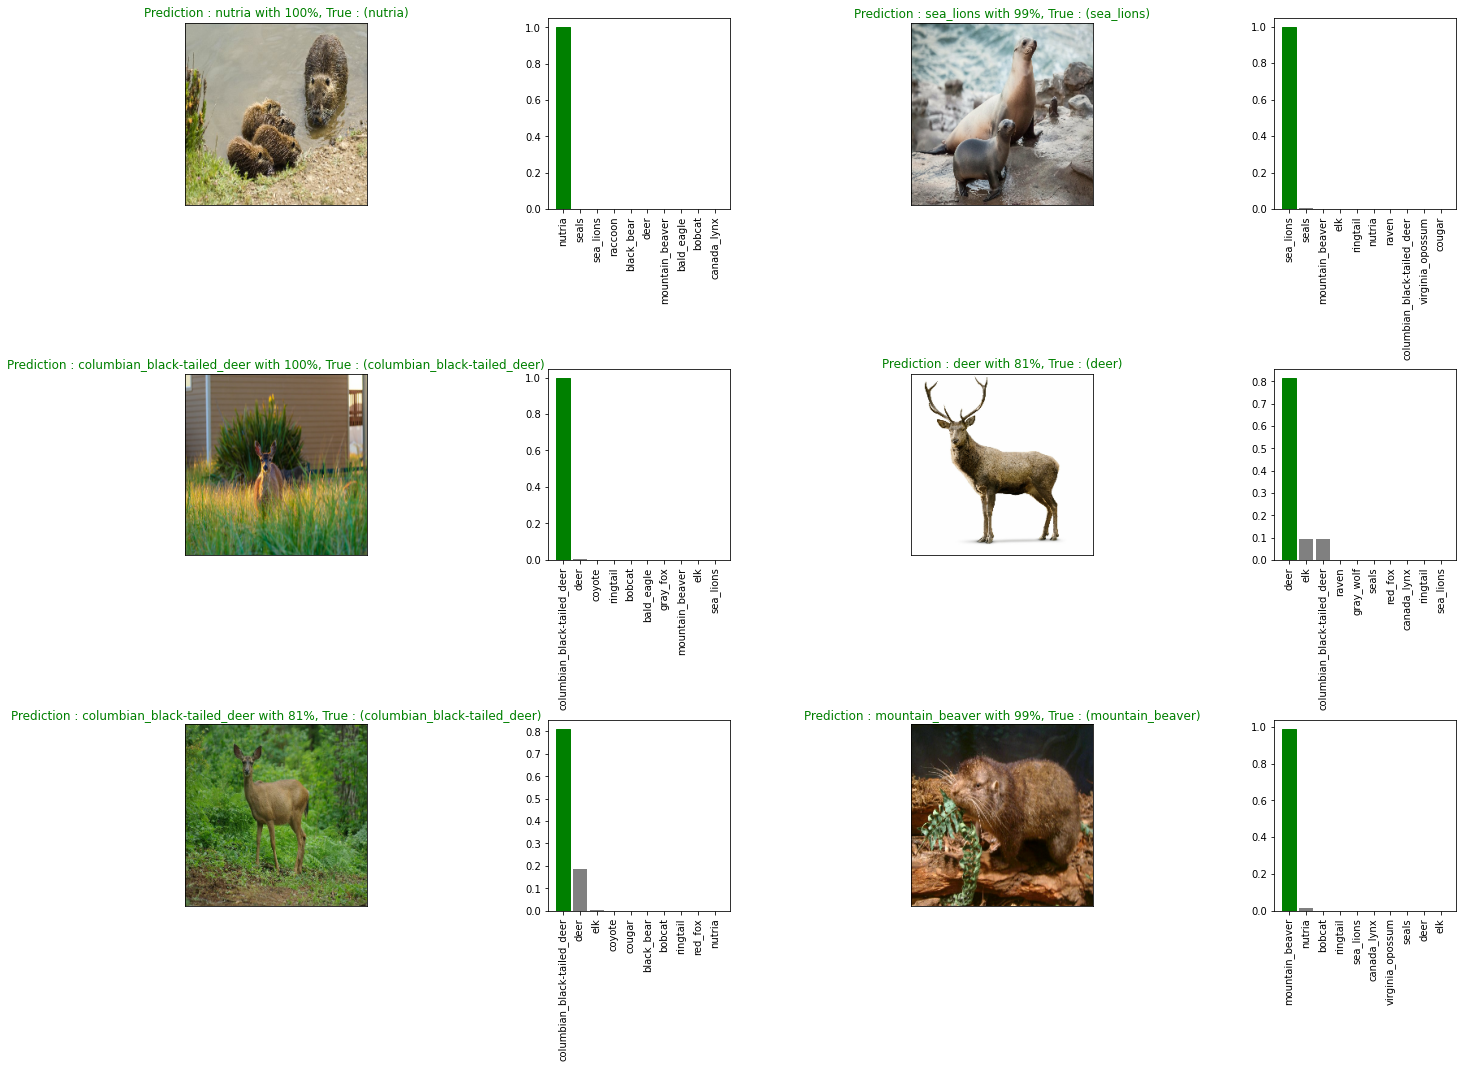

In [117]:
# let's check a few predictions and their different values
i_multiplier = 0
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(5*2*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(predictions=test_predictions,
          labels=test_labels,
          images=test_images,
          n=i * 3 + i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(predictions=test_predictions,
               labels=test_labels,
               n=i * 3 + i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

Let's check how many images were predicted wrong on a test data.

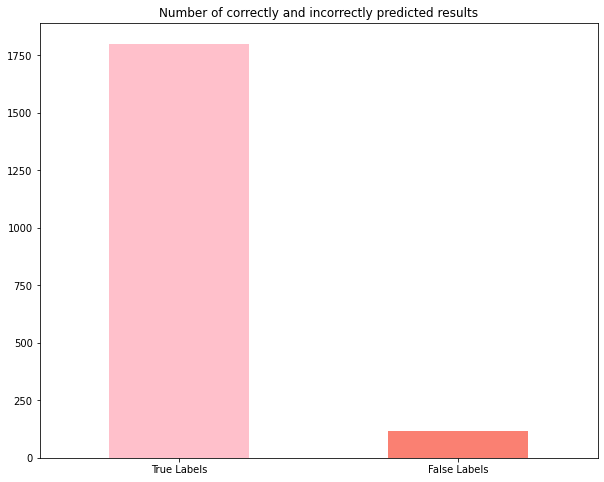

In [141]:
true_labels, false_labels = 0, 0
for index, prediction in enumerate(test_predictions):
  prediction_label = get_prediction_label(prediction)
  true_label = kind_animal[np.argmax(y_test[index])]
  if prediction_label == true_label:
    true_labels += 1
  else:
    false_labels += 1

series = pd.Series(data={'True Labels': true_labels, 'False Labels': false_labels})
series.plot(kind='bar', color=['pink', 'salmon'], figsize=(10, 8));
plt.title("Number of correctly and incorrectly predicted results");
plt.xticks(rotation='horizontal');

## Making predictions on custom images

To do it, we'll:

* Get the filepaths of images
* Turn them into data batches.
* Make predictions by `predict()`.
* Visualize results.

In [181]:
# get custom files
custom_path = '/content/drive/MyDrive/Oregon_Wildlife/checking/'
custom_images_path = [custom_path + filepath for filepath in os.listdir(custom_path)]

In [183]:
# turn images into batches
custom_data = create_data_batches(custom_images_path, test_data=True)

Creating test data batches...
Test data batches created!


In [184]:
# make predictions
custom_predictions = model_mobile_net_trained.predict(custom_data)

In [185]:
# get custom predictions labels
custom_prediction_labels = [get_prediction_label(cp) for cp in custom_predictions]

In [186]:
# unbatcify data
custom_images = next(custom_data.as_numpy_iterator())

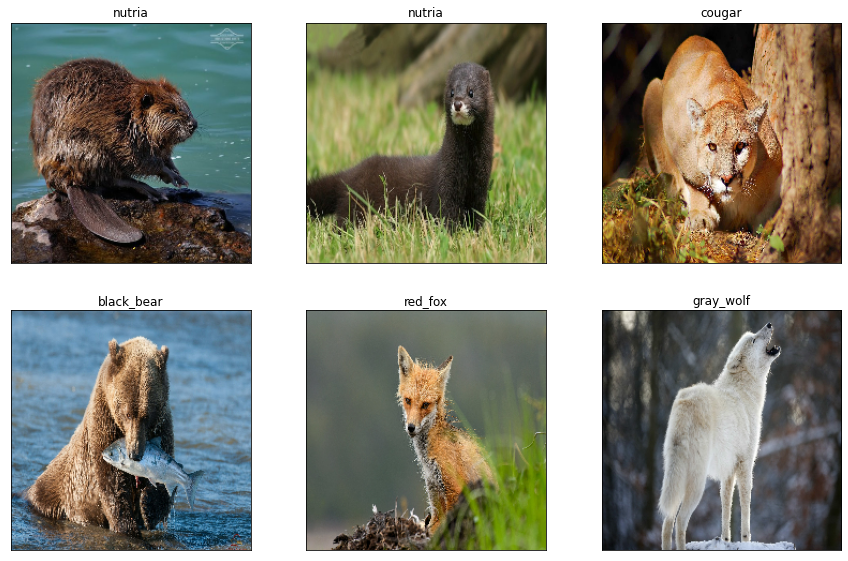

In [187]:
# check custom image predictions
plt.figure(figsize=(15, 15))
for i, image in enumerate(custom_images):
  plt.subplot(3, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_prediction_labels[i])
  plt.imshow(image)